In [1]:
from qiskit import *
from zero_noise_extrapolation import *
import numpy as np
import pylab as pl
from qiskit.providers.jobstatus import JOB_FINAL_STATES, JobStatus

In [2]:
import sys
sys.path.append('../')

from qiskit_utilities.utilities import *

In [3]:
# show all output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

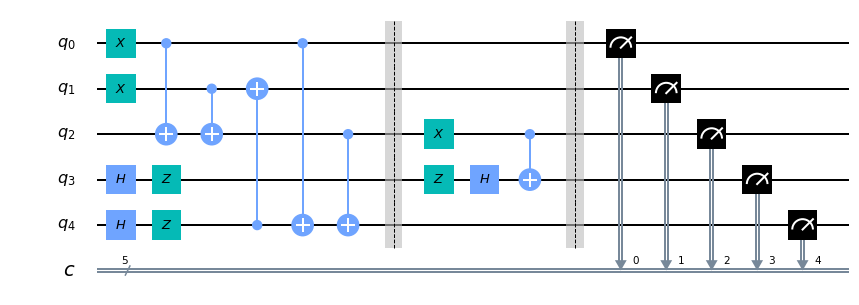

In [4]:
def get_maxs_poker_circuit(usebarrier=False, measure=True, applynotpos=-1):
    circ = "OPENQASM 2.0;\ninclude \"qelib1.inc\"; \
    qreg q[5];\
    creg c[5];"
    if applynotpos>-1 and applynotpos<5:
        circ = circ + "x q["+str(applynotpos)+"];"
    circ = circ + "x q[0];\
    x q[1];\
    h q[3];\
    z q[3];\
    h q[4];\
    z q[4];\
    cx q[0],q[2];\
    cx q[1],q[2];\
    cx q[4],q[1];\
    cx q[0],q[4];\
    cx q[2],q[4];"
    if usebarrier:
        circ = circ + "barrier q[0],q[1],q[2],q[3],q[4]; "
    circ = circ + "x q[2];\
    z q[3];\
    h q[3];\
    cx q[2],q[3];"
    if usebarrier:
        circ = circ + "barrier q[0],q[1],q[2],q[3],q[4]; "
    if measure:
        circ = circ + "measure q[0] -> c[0]; \
        measure q[1] -> c[1]; \
        measure q[2] -> c[2]; \
        measure q[3] -> c[3]; \
        measure q[4] -> c[4]; "
    qc = QuantumCircuit.from_qasm_str(circ)
    return qc

get_maxs_poker_circuit(True).draw(output='mpl')

In [5]:
jobs_dict={}
E_dict={}
E_av_dict={}
mean_depth_dict={}
mean_depth_transpiled_dict={}
max_depth_dict={}
max_depth_transpiled_dict={}
backends_dict={}
noisemodels_dict={}
coupling_maps_dict={}
basis_gates_dict={}
cx_error_maps_dict={}

In [6]:
import pickle
import os

In [7]:
if os.path.isfile('E_Pokerdata'):
    infile = open('data/E_Pokerdata','rb')
    E_dict = pickle.load(infile)
    infile.close()
    
if os.path.isfile('E_av_Pokerdata'):
    infile = open('data/E_av_Pokerdata','rb')
    E_av_dict = pickle.load(infile)
    infile.close()

if os.path.isfile('data/mean_depth_Pokerdata'):
    infile = open('data/mean_depth_Pokerdata','rb')
    mean_depth_dict = pickle.load(infile)
    infile.close()
    
if os.path.isfile('data/mean_depth_transpiled_Pokerdata'):
    infile = open('data/mean_depth_transpiled_Pokerdata','rb')
    mean_depth_transpiled_dict = pickle.load(infile)
    infile.close()

if os.path.isfile('data/max_depth_Pokerdata'):
    infile = open('data/max_depth_Pokerdata','rb')
    max_depth_dict = pickle.load(infile)
    infile.close()

if os.path.isfile('data/max_depth_transpiled_Pokerdata'):
    infile = open('data/max_depth_transpiled_Pokerdata','rb')
    max_depth_transpiled_dict = pickle.load(infile)
    infile.close()

Let us first create a dictionary with backends we are going to use

In [8]:
backendname_sim = 'qasm_simulator'
backends_dict[backendname_sim] = Aer.get_backend(backendname_sim)

#load IBMQ account
IBMQ.save_account('yourToken')
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

backendname_x2 = 'ibmqx2'
backendname_ourense = 'ibmq_ourense'

for backendname in [backendname_x2, backendname_ourense]:
    backends_dict[backendname] = provider.get_backend(backendname)

Credentials already present. Set overwrite=True to overwrite.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

Next, let us create some noise models for the ibm quantum devices

In [9]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.device import basic_device_noise_model

for backendname in [backendname_x2, backendname_ourense]:
    backend = backends_dict[backendname]

    noisemodels_dict[backendname] = basic_device_noise_model(backend.properties())
    cx_error_maps_dict[backendname] = get_cx_error_map(backend)
    coupling_maps_dict[backendname] = backend.configuration().coupling_map
    basis_gates_dict[backendname] = noisemodels_dict[backendname].basis_gates

noisemodels_dict['None'] = None

Next, we implement how the expectation value of our observable is defined, and how to extract it from the executed jobs

In [10]:
numones=np.zeros((2**5,1))
for i in range(2**5):
    numones[i]=bin(i).count("1")

In [11]:
def expectationValue(results):
    #num_qubits = results[0].header.n_qubits
    E=np.zeros((len(results),1))
    for item in range(0,len(results)):
        shots = results[item].shots
        counts = results[item].data.counts
        for key in list(counts.__dict__.keys()):
            c=getattr(counts, key)#number of counts
            E[item] += numones[int(key,0)]*c/shots
    return E

In [12]:
def getE(jobstring, numparts):
    for p in range(1, numparts+1):
        filename = jobstring+'_part_'+str(p)
        results = read_results(filename)
        if results == None:
            return None, None, False
        if p==1:
            E = expectationValue(results)
        else:
            E = np.append(E, expectationValue(results))

    E_conv = np.zeros_like(E)
    for j in range(1,num_repetitions+1):
        E_conv[j-1] = sum(E[0:j])/j
    return E, E_conv, True

Let us start by simulating the circuit on an ideal simulator without noise

in all simulations we will use the same number repetitions, where each repetition consists of shots

on real ibm devices we are only allowed $2^6$ circuits in parallel, therefore we need to do $2^4$ parts in order to get $2^{10}$ repetitions in total

In [13]:
num_circuits=2**6
num_parts=2**4
num_repetitions = num_circuits*num_parts
shots = 1024*2*2*2

Read the expectation values from file, or execute the circuits on a simulator

In [14]:
backendname = backendname_sim
circuit = get_maxs_poker_circuit()
noisemodelname = "None"

paulitwirling=False

for r in (1, 2, 4, 8, 16, 32):
    basename='backend_'+backendname+'_shots_'+str(shots) \
        +'_noisemodel_'+noisemodelname+'_errorlevel_'+str(r) \
        +'_paulitwirling_'+str(paulitwirling) \
        +'_numcircuits_'+str(num_circuits)
    ### get Expectation value if results exist as files
    E_tmp, E_av_tmp, success = getE(basename, num_parts)
    if success:
        E_dict[basename] = E_tmp
        E_av_dict[basename] = E_av_tmp
        #print('success')
    else:
        mean_depth=0
        max_depth=0
        for p in range(1, num_parts+1):
            circuits_r=[]
            for i in range(1, num_circuits+1):
                circ_tmp = create_Paulitwirled_and_noiseamplified_circuit(circuit, r, cx_error_maps_dict[backendname_x2], paulitwirling)
                circuits_r.append(circ_tmp)
                depth=circuits_r[-1].depth()
                mean_depth += depth
                max_depth = max(max_depth,depth)
                
            job_string = basename +'_part_'+str(p)
            print('job=',job_string)
            jobs_dict[job_string] = execute(circuits_r, backends_dict[backendname], shots=shots)

            mean_depth_dict[basename] = mean_depth/num_repetitions
            max_depth_dict[basename] = max_depth

success
success
success
success
success
success


write the results to file, if not already done and calculate expectation values

In [15]:
backendname = backendname_sim
circuit = get_maxs_poker_circuit()
noisemodelname = "None"

paulitwirling=False

for r in (1, 2, 4, 8, 16, 32):
    basename='backend_'+backendname+'_shots_'+str(shots) \
        +'_noisemodel_'+noisemodelname+'_errorlevel_'+str(r) \
        +'_paulitwirling_'+str(paulitwirling) \
        +'_numcircuits_'+str(num_circuits)
    if not(basename in E_dict):
        for p in range(1, num_parts+1):
            job_string = basename +'_part_'+str(p)
            success = write_results(job_string, jobs_dict[job_string])

        E_dict[basename], E_av_dict[basename], success = getE(basename, num_parts)

<Figure size 800x480 with 0 Axes>

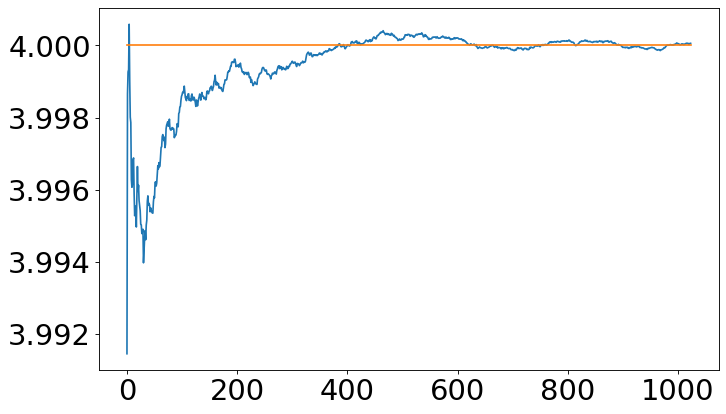

In [16]:
font = {'size' : 26}
pl.matplotlib.rc('font', **font)
pl.figure(1,figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k')

r=1
paulitwirling=False
basename='backend_'+backendname+'_shots_'+str(shots) \
    +'_noisemodel_'+noisemodelname+'_errorlevel_'+str(r) \
    +'_paulitwirling_'+str(paulitwirling) \
    +'_numcircuits_'+str(num_circuits)

pl.plot(E_av_dict[basename])
pl.plot(4*np.ones_like(E_av_dict[basename]))

Now, let us simulate, using a noise model

First, we need to create circuits that can be directly executed on a device

In [17]:
rep=256

opt_level=1
for ind in range(rep):
    trans_circ = transpile(get_maxs_poker_circuit(),\
                           backend=backends_dict[backendname_x2], optimization_level=opt_level)
    num_cx = getNumberOfControlledGates(trans_circ)[0]
    depth=trans_circ.depth()
    if ind==0:
        circ_x2 = trans_circ
        num_cx_max = num_cx
        num_cx_min = num_cx
        depth_min=depth
    else:
        num_cx_max = max(num_cx, num_cx_max)
        # if the circuit has less cx gates, we choose it as the best circuit
        if num_cx < num_cx_min:
            circ_x2 = trans_circ
            num_cx_min = num_cx
        # if the circuit has the same number of cx gates, we choose the one with the shortest depth
        elif num_cx == num_cx_min and depth<depth_min:
            circ_x2 = trans_circ
            depth_min=depth
            
    print(ind, 'minimum CX gates for IBMQ X2 opt level=',opt_level,' is: ',num_cx_min,' depth = ', depth_min,\
          'this time: ', num_cx, 'depth = ', depth, end='     \r')
print('minimum CX gates for IBMQ X2 opt level=',opt_level,' is: ',num_cx_min,' depth = ', depth_min, '                         ')

rep=256
opt_level=3
for ind in range(rep):
    trans_circ = transpile(get_maxs_poker_circuit(),\
                           backend=backends_dict[backendname_ourense], optimization_level=opt_level)
    num_cx = getNumberOfControlledGates(trans_circ)[0]
    depth=trans_circ.depth()
    if ind==0:
        circ_ourense = trans_circ
        num_cx_max = num_cx
        num_cx_min = num_cx
        depth_min=depth
    else:
        num_cx_max = max(num_cx, num_cx_max)
        # if the circuit has less cx gates, we choose it as the best circuit
        if num_cx < num_cx_min:
            circ_ourense = trans_circ
            num_cx_min = num_cx
        # if the circuit has the same number of cx gates, we choose the one with the shortest depth
        elif num_cx == num_cx_min and depth<depth_min:
            circ_ourense = trans_circ
            depth_min=depth
            
    print(ind, 'minimum CX gates for IBMQ ourense opt level=',opt_level,' is: ',num_cx_min,' depth = ', depth_min,\
          'this time: ', num_cx, 'depth = ', depth)
print('um CX gates for IBMQ ourense opt level=',opt_level,' is: ',num_cx_min,' depth = ', depth_min, '                         ')


ates for IBMQ ourense opt level= 3  is:  9  depth =  18 this time:  17 depth =  24
55 minimum CX gates for IBMQ ourense opt level= 3  is:  9  depth =  18 this time:  9 depth =  18
56 minimum CX gates for IBMQ ourense opt level= 3  is:  9  depth =  18 this time:  14 depth =  18
57 minimum CX gates for IBMQ ourense opt level= 3  is:  9  depth =  18 this time:  9 depth =  18
58 minimum CX gates for IBMQ ourense opt level= 3  is:  9  depth =  18 this time:  17 depth =  21
59 minimum CX gates for IBMQ ourense opt level= 3  is:  9  depth =  18 this time:  12 depth =  22
60 minimum CX gates for IBMQ ourense opt level= 3  is:  9  depth =  18 this time:  14 depth =  18
61 minimum CX gates for IBMQ ourense opt level= 3  is:  9  depth =  18 this time:  12 depth =  22
62 minimum CX gates for IBMQ ourense opt level= 3  is:  9  depth =  18 this time:  14 depth =  19
63 minimum CX gates for IBMQ ourense opt level= 3  is:  9  depth =  18 this time:  9 depth =  18
64 minimum CX gates for IBMQ ourense o

Let us plot what the transpiled circuits look like

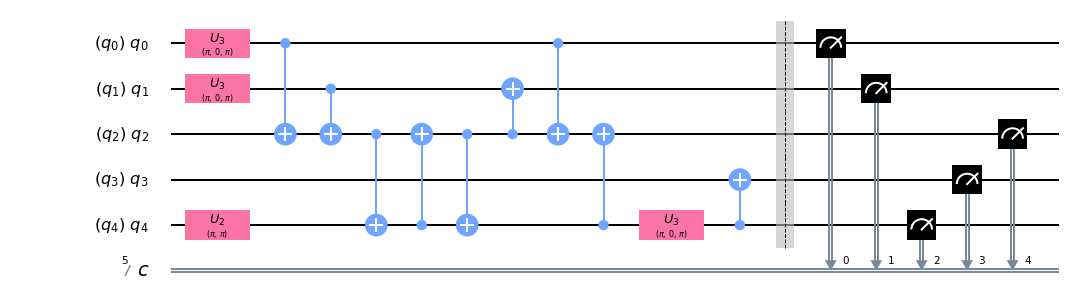

circuit depth =  12


In [18]:
circ_x2.draw(output='mpl')
print('circuit depth = ',circ_x2.depth())

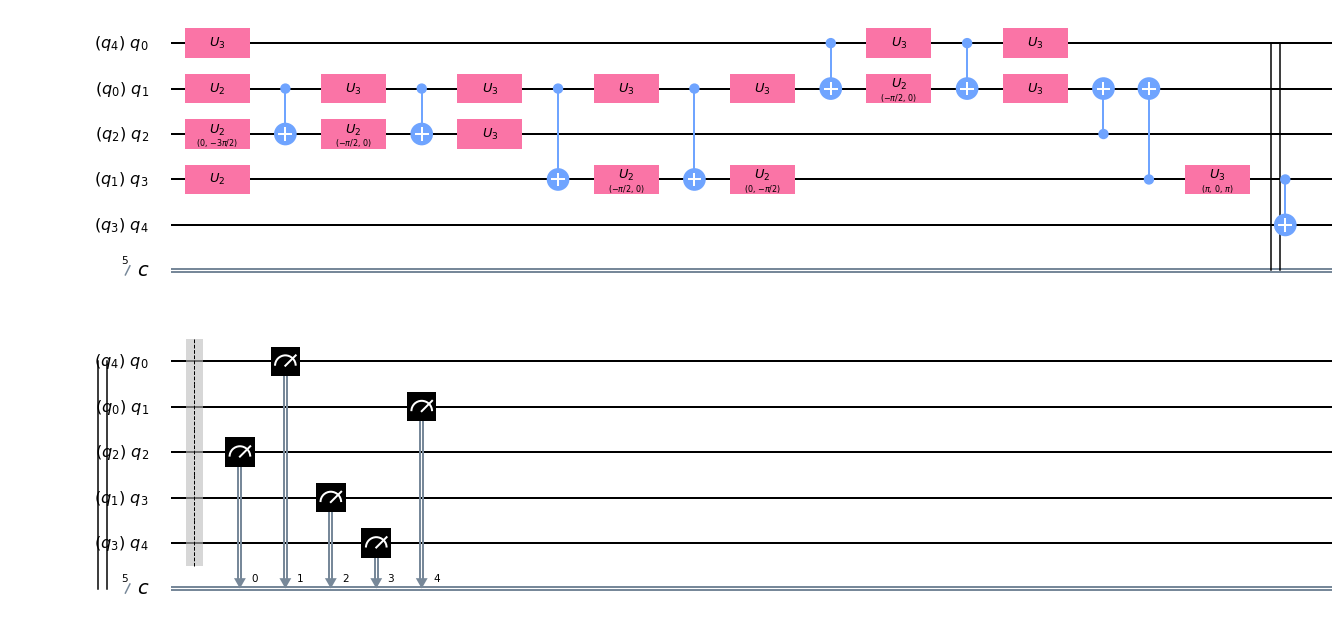

circuit depth =  18


In [19]:
circ_ourense.draw(output='mpl')
print('circuit depth = ',circ_ourense.depth())

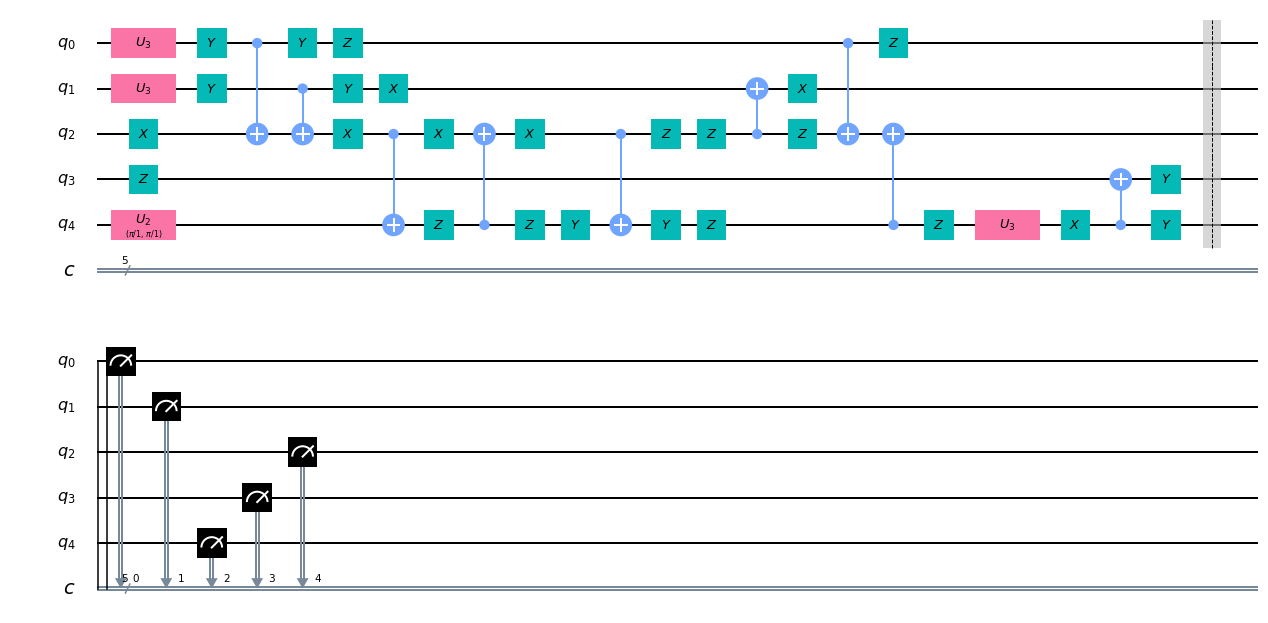

circuit depth =  23


In [20]:
circ_tmp = create_Paulitwirled_and_noiseamplified_circuit(circ_x2, 8, cx_error_maps_dict[backendname_x2], True)
circ_tmp.draw(output='mpl')
print('circuit depth = ',circ_tmp.depth())

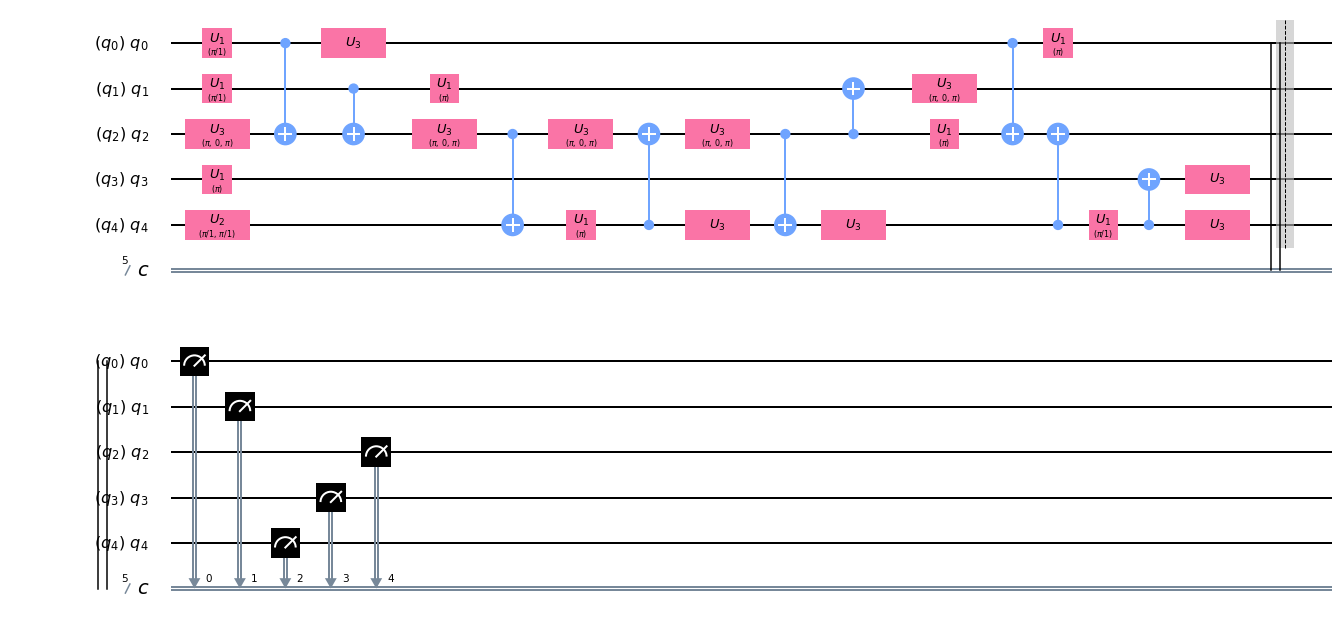

circuit depth =  17


In [21]:
circ_tmp_tp=transpile(circ_tmp, backend=backends_dict[backendname_x2], optimization_level=1)
circ_tmp_tp.draw(output='mpl')
print('circuit depth = ',circ_tmp_tp.depth())

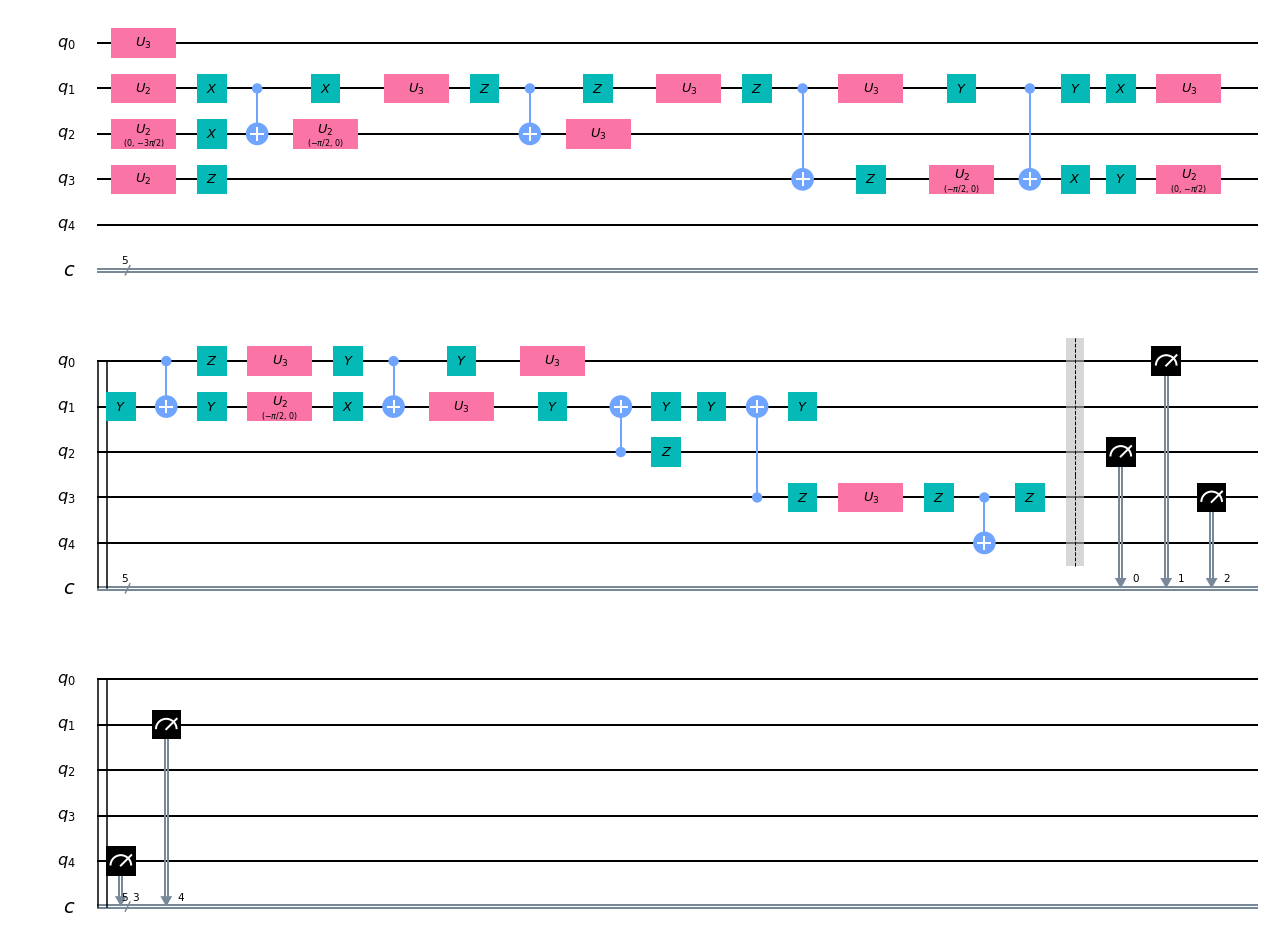

circuit depth =  17


In [22]:
circ_tmp = create_Paulitwirled_and_noiseamplified_circuit(\
                circ_ourense, 8, cx_error_maps_dict[backendname_ourense], True)
circ_tmp.draw(output='mpl')
print('circuit depth = ',circ_tmp_tp.depth())

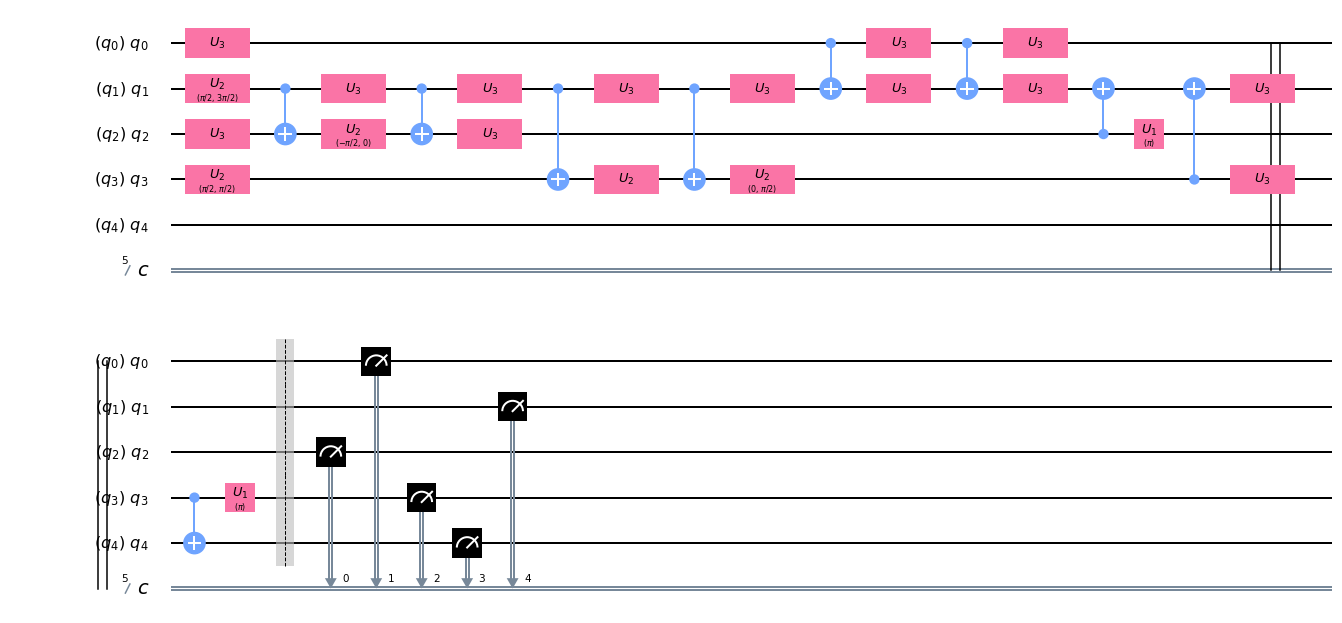

circuit depth =  17


In [23]:
transpile(circ_tmp, backend=backends_dict[backendname_ourense], optimization_level=1).draw(output='mpl')
print('circuit depth = ',circ_tmp_tp.depth())

Create circuits with and without Pauli twirling and with different error amplification factors

These are then executed on a simulator with a noise model for a given device

In [25]:
backendname = backendname_sim
k = 0
N = num_parts*num_circuits*2*2*12
for noisemodelname in [backendname_x2, backendname_ourense]:

    if noisemodelname==backendname_x2:
        circuit = circ_x2
    elif noisemodelname==backendname_ourense:
        circuit = circ_ourense

    for r in (1, 1.5, 2, 2.5, 3, 3.5, 4, 8, 12, 16, 24, 32):
        for paulitwirling in (True, False):
            basename='backend_'+backendname+'_shots_'+str(shots) \
                +'_noisemodel_'+noisemodelname+'_errorlevel_'+str(r) \
                +'_paulitwirling_'+str(paulitwirling) \
                +'_numcircuits_'+str(num_circuits)
            ### get Expectation value if results exist as files
            E_tmp, E_av_tmp, success = getE(basename, num_parts)
            if success:
                E_dict[basename] = E_tmp
                E_av_dict[basename] = E_av_tmp
            else:
                mean_depth=0
                max_depth=0
                mean_depth_transpiled=0
                max_depth_transpiled=0
                
                for p in range(1, num_parts+1):
                    circuits_r=[]
                    for i in range(1, num_circuits+1):
                        k += 1
                        circ_tmp = create_Paulitwirled_and_noiseamplified_circuit(\
                                        circuit, r, cx_error_maps_dict[noisemodelname], paulitwirling)
                        depth = circ_tmp.depth()
                        mean_depth += depth
                        max_depth = max(max_depth,depth)
                        # now we can transpile to combine single qubit gates, etc.
                        #circuits_r.append(circ_tmp)
                        circuits_r.append(transpile(circ_tmp, backend=backends_dict[noisemodelname], optimization_level=1))
                        depth=circuits_r[-1].depth()
                        mean_depth_transpiled += depth
                        max_depth_transpiled = max(max_depth_transpiled,depth)
                    job_string = basename +'_part_'+str(p)
                    ratio = 100*k/N
                    print('job=',job_string, k, '/', N, ',  ', ratio, '% done.')
                    jobs_dict[job_string] = execute(circuits_r, backends_dict[backendname],\
                                                noise_model=noisemodels_dict[noisemodelname],\
                                                basis_gates=basis_gates_dict[noisemodelname],\
                                                shots=shots)

                mean_depth_dict[basename] = mean_depth/num_repetitions
                max_depth_dict[basename] = max_depth
                mean_depth_transpiled_dict[basename] = mean_depth_transpiled/num_repetitions
                max_depth_transpiled_dict[basename] = max_depth_transpiled

% done.
job= backend_qasm_simulator_shots_8192_noisemodel_ibmq_ourense_errorlevel_12_paulitwirling_True_numcircuits_64_part_4 41216 / 49152 ,   83.85416666666667 % done.
job= backend_qasm_simulator_shots_8192_noisemodel_ibmq_ourense_errorlevel_12_paulitwirling_True_numcircuits_64_part_5 41280 / 49152 ,   83.984375 % done.
job= backend_qasm_simulator_shots_8192_noisemodel_ibmq_ourense_errorlevel_12_paulitwirling_True_numcircuits_64_part_6 41344 / 49152 ,   84.11458333333333 % done.
job= backend_qasm_simulator_shots_8192_noisemodel_ibmq_ourense_errorlevel_12_paulitwirling_True_numcircuits_64_part_7 41408 / 49152 ,   84.24479166666667 % done.
job= backend_qasm_simulator_shots_8192_noisemodel_ibmq_ourense_errorlevel_12_paulitwirling_True_numcircuits_64_part_8 41472 / 49152 ,   84.375 % done.
job= backend_qasm_simulator_shots_8192_noisemodel_ibmq_ourense_errorlevel_12_paulitwirling_True_numcircuits_64_part_9 41536 / 49152 ,   84.50520833333333 % done.
job= backend_qasm_simulator_shots_8192_

In [26]:
backendname = backendname_sim
for noisemodelname in [backendname_x2, backendname_ourense]:

    for r in (1, 1.5, 2, 2.5, 3, 3.5, 4, 8, 12, 16, 24, 32):
        for paulitwirling in (True, False):
            basename='backend_'+backendname+'_shots_'+str(shots) \
                +'_noisemodel_'+noisemodelname+'_errorlevel_'+str(r) \
                +'_paulitwirling_'+str(paulitwirling) \
                +'_numcircuits_'+str(num_circuits)
            if not(basename in E_dict):
                for p in range(1, num_parts+1):
                    print('r =', r, ' twirling =', paulitwirling, 'p =', p)
                    job_string = basename +'_part_'+str(p)
                    success = write_results(job_string, jobs_dict[job_string])

                E_dict[basename], E_av_dict[basename], success = getE(basename, num_parts)


r = 2.5  twirling = False p = 7
r = 2.5  twirling = False p = 8
r = 2.5  twirling = False p = 9
r = 2.5  twirling = False p = 10
r = 2.5  twirling = False p = 11
r = 2.5  twirling = False p = 12
r = 2.5  twirling = False p = 13
r = 2.5  twirling = False p = 14
r = 2.5  twirling = False p = 15
r = 2.5  twirling = False p = 16
r = 3  twirling = True p = 1
r = 3  twirling = True p = 2
r = 3  twirling = True p = 3
r = 3  twirling = True p = 4
r = 3  twirling = True p = 5
r = 3  twirling = True p = 6
r = 3  twirling = True p = 7
r = 3  twirling = True p = 8
r = 3  twirling = True p = 9
r = 3  twirling = True p = 10
r = 3  twirling = True p = 11
r = 3  twirling = True p = 12
r = 3  twirling = True p = 13
r = 3  twirling = True p = 14
r = 3  twirling = True p = 15
r = 3  twirling = True p = 16
r = 3  twirling = False p = 1
r = 3  twirling = False p = 2
r = 3  twirling = False p = 3
r = 3  twirling = False p = 4
r = 3  twirling = False p = 5
r = 3  twirling = False p = 6
r = 3  twirling = Fal

(2.5, 4.001)

(2.5, 4.001)

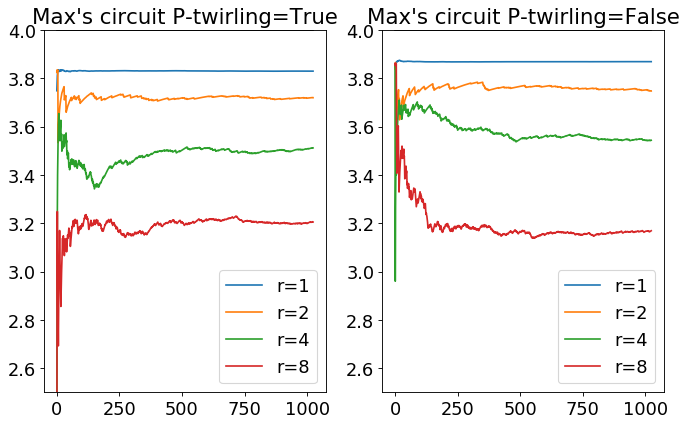

In [27]:
backendname = backendname_sim
noisemodelname = backendname_x2

font = {'size' : 16}
pl.matplotlib.rc('font', **font)
f = pl.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k')

ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)


paulitwirling=True
for r in [1,2,4,8]:
    basename='backend_'+backendname+'_shots_'+str(shots) \
        +'_noisemodel_'+noisemodelname+'_errorlevel_'+str(r) \
        +'_paulitwirling_'+str(paulitwirling) \
        +'_numcircuits_'+str(num_circuits)
    ax1.plot(E_av_dict[basename],'-',label='r='+str(r))

ax1.title.set_text('Max\'s circuit P-twirling='+str(paulitwirling))
ax1.plot(4*np.ones_like(E_av_dict[basename]),'k-')
ax1.set_ylim(top=4.001,bottom=2.5)
ax1.legend()

paulitwirling=False
for r in [1,2,4,8]:
    basename='backend_'+backendname+'_shots_'+str(shots) \
        +'_noisemodel_'+noisemodelname+'_errorlevel_'+str(r) \
        +'_paulitwirling_'+str(paulitwirling) \
        +'_numcircuits_'+str(num_circuits)
    ax2.plot(E_av_dict[basename],'-',label='r='+str(r))

ax2.title.set_text('Max\'s circuit P-twirling='+str(paulitwirling))
ax2.plot(4*np.ones_like(E_av_dict[basename]),'k-')
ax2.set_ylim(top=4.001,bottom=2.5)
ax2.legend()

(2.5, 4.001)

(2.5, 4.001)

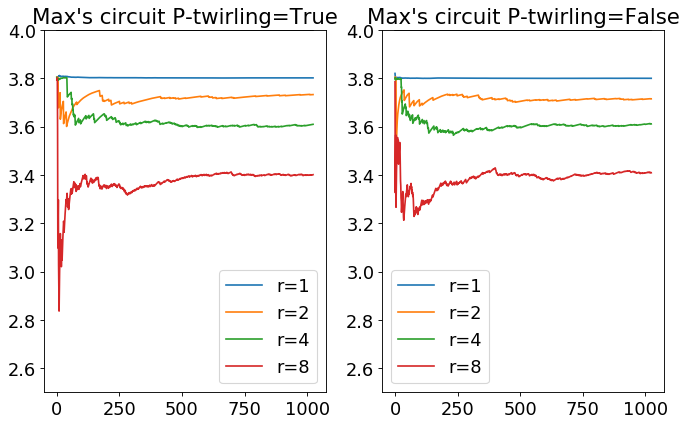

In [28]:
backendname = backendname_sim
noisemodelname = backendname_ourense

font = {'size' : 16}
pl.matplotlib.rc('font', **font)
f = pl.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k')

ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)


paulitwirling=True
for r in [1,2,4,8]:
    basename='backend_'+backendname+'_shots_'+str(shots) \
        +'_noisemodel_'+noisemodelname+'_errorlevel_'+str(r) \
        +'_paulitwirling_'+str(paulitwirling) \
        +'_numcircuits_'+str(num_circuits)
    ax1.plot(E_av_dict[basename],'-',label='r='+str(r))

ax1.title.set_text('Max\'s circuit P-twirling='+str(paulitwirling))
ax1.plot(4*np.ones_like(E_av_dict[basename]),'k-')
ax1.set_ylim(top=4.001,bottom=2.5)
ax1.legend()

paulitwirling=False
for r in [1,2,4,8]:
    basename='backend_'+backendname+'_shots_'+str(shots) \
        +'_noisemodel_'+noisemodelname+'_errorlevel_'+str(r) \
        +'_paulitwirling_'+str(paulitwirling) \
        +'_numcircuits_'+str(num_circuits)
    ax2.plot(E_av_dict[basename],'-',label='r='+str(r))

ax2.title.set_text('Max\'s circuit P-twirling='+str(paulitwirling))
ax2.plot(4*np.ones_like(E_av_dict[basename]),'k-')
ax2.set_ylim(top=4.001,bottom=2.5)
ax2.legend()

Run on a real quantum computer

In [5]:
k = 0
N = num_circuits*num_parts*2*12
for paulitwirling in (True, False):
    for backendname in [backendname_x2, backendname_ourense]:
        noisemodelname = backendname
        
        if backendname == backendname_x2:
            circuit = circ_x2
        elif backendname == backendname_ourense:
            circuit = circ_ourense

        for r in (1, 1.5, 2, 2.5, 3, 3.5, 4, 8, 12, 16, 24, 32):
            basename='backend_'+backendname+'_shots_'+str(shots) \
                +'_noisemodel_'+noisemodelname+'_errorlevel_'+str(r) \
                +'_paulitwirling_'+str(paulitwirling) \
                +'_numcircuits_'+str(num_circuits)
            ### get Expectation value if results exist as files
            E_tmp, E_av_tmp, success = getE(basename, num_parts)
            if success:
                E_dict[basename] = E_tmp
                E_av_dict[basename] = E_av_tmp
            else:
                mean_depth=0
                max_depth=0
                mean_depth_transpiled=0
                max_depth_transpiled=0
                for p in range(1, num_parts+1):
                    circuits_r=[]
                    for i in range(1, num_circuits+1):
                        k +=1
                        circ_tmp = create_Paulitwirled_and_noiseamplified_circuit(\
                                        circuit, r, cx_error_maps_dict[noisemodelname], paulitwirling)
                        depth = circ_tmp.depth()
                        mean_depth += depth
                        max_depth = max(max_depth,depth)
                        # now we can transpile to combine single qubit gates, etc.
                        #circuits_r.append(circ_tmp)
                        circuits_r.append(transpile(circ_tmp, backend=backends_dict[backendname], optimization_level=1))
                        depth=circuits_r[-1].depth()
                        mean_depth_transpiled += depth
                        max_depth_transpiled = max(max_depth_transpiled,depth)
                    job_string = basename +'_part_'+str(p)
                    ratio = 100*k/N
                    print('job=',job_string, k, '/', N, ', ', ratio, '% done.')
                    jobs_dict[job_string] = start_or_retrieve_job(job_string,\
                                                                  backends_dict[backendname],\
                                                                  circuits_r,\
                                                                  options={'shots' : shots})

                mean_depth_dict[basename] = mean_depth/num_repetitions
                max_depth_dict[basename] = max_depth
                mean_depth_transpiled_dict[basename] = mean_depth_transpiled/num_repetitions
                max_depth_transpiled_dict[basename] = max_depth_transpiled

NameError: name 'backendname_x2' is not defined

In [6]:
for paulitwirling in (True, False):
    for backendname in [backendname_x2, backendname_ourense]:
        noisemodelname = backendname
        for r in (1, 1.5, 2, 2.5, 3, 3.5, 4, 8, 12, 16, 24, 32):
            basename='backend_'+backendname+'_shots_'+str(shots) \
                +'_noisemodel_'+noisemodelname+'_errorlevel_'+str(r) \
                +'_paulitwirling_'+str(paulitwirling) \
                +'_numcircuits_'+str(num_circuits)
            if not(basename in E_dict):
                for p in range(1, num_parts+1):
                    job_string = basename +'_part_'+str(p)
                    success = write_results(job_string, jobs_dict[job_string])

                E_dict[basename], E_av_dict[basename], success = getE(basename, num_parts)

NameError: name 'backendname_x2' is not defined

In [7]:
for backendname in [backendname_x2, backendname_ourense]:
    
    if backendname == backendname_x2:
        noisemodelname = backendname_x2
    elif backendname == backendname_ourense:
        noisemodelname = backendname_ourense
        
    r = 1
    paulitwirling=True
    basename='backend_'+backendname+'_shots_'+str(shots) \
        +'_noisemodel_'+noisemodelname+'_errorlevel_'+str(r) \
        +'_paulitwirling_'+str(paulitwirling) \
        +'_numcircuits_'+str(num_circuits)
    pl.plot(E_av_dict[basename],label=backendname);
pl.legend();

NameError: name 'backendname_x2' is not defined

In [8]:
backendname = backendname_x2
noisemodelname = backendname_x2

font = {'size' : 16}
pl.matplotlib.rc('font', **font);
f = pl.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k');

ax1 = f.add_subplot(121);
ax2 = f.add_subplot(122);


for paulitwirling in [True, False]:
    if paulitwirling:
        ax = ax1
    else:
        ax = ax2
    for r in [1,2,4,8]:
        basename='backend_'+backendname+'_shots_'+str(shots) \
            +'_noisemodel_'+noisemodelname+'_errorlevel_'+str(r) \
            +'_paulitwirling_'+str(paulitwirling) \
            +'_numcircuits_'+str(num_circuits)
            
        ax.plot(E_av_dict[basename],'-',label='r='+str(r));
   
    ax.title.set_text('Max\'s circuit P-twirling='+str(paulitwirling));
    ax.plot(4*np.ones_like(E_av_dict[basename]),'k-',label='ideal');
    ax.set_ylim(top=4.1,bottom=2.5);
    ax.legend();

NameError: name 'backendname_x2' is not defined

In [9]:
backendname = backendname_ourense
noisemodelname = backendname_ourense

font = {'size' : 16}
pl.matplotlib.rc('font', **font);
f = pl.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k');

ax1 = f.add_subplot(121);
ax2 = f.add_subplot(122);


for paulitwirling in [True, False]:
    if paulitwirling:
        ax = ax1
    else:
        ax = ax2
    for r in [1,2,4,8]:
        basename='backend_'+backendname+'_shots_'+str(shots) \
            +'_noisemodel_'+noisemodelname+'_errorlevel_'+str(r) \
            +'_paulitwirling_'+str(paulitwirling) \
            +'_numcircuits_'+str(num_circuits)
            
        ax.plot(E_av_dict[basename],'-',label='r='+str(r));
   
    ax.title.set_text('Max\'s circuit P-twirling='+str(paulitwirling));
    ax.plot(4*np.ones_like(E_av_dict[basename]),'k-',label='ideal');
    ax.set_ylim(top=4.1,bottom=2.5);
    ax.legend();

NameError: name 'backendname_ourense' is not defined

In [10]:
font = {'size' : 16}
pl.matplotlib.rc('font', **font)

backendname = backendname_ourense
noisemodelname = backendname_ourense

backendname = backendname_sim
noisemodelname = backendname_x2
fn=0
Rstring=""
for backendname in [backendname_sim, backendname_sim, backendname_x2, backendname_ourense]:
    if fn%2==0:
        noisemodelname=backendname_x2
    else:
        noisemodelname=backendname_ourense
    fn+=1

    f = pl.figure(fn,figsize=(20, 6), dpi= 80, facecolor='w', edgecolor='k');

    ax1 = f.add_subplot(121);
    ax2 = f.add_subplot(122);


    for paulitwirling in [True, False]:
        if paulitwirling:
            ax = ax1
        else:
            ax = ax2
        bnames={}
        for r in [1,2,4,8,16,32]:
            bnames[str(r)]='backend_'+backendname+'_shots_'+str(shots) \
                +'_noisemodel_'+noisemodelname+'_errorlevel_'+str(r) \
                +'_paulitwirling_'+str(paulitwirling) \
                +'_numcircuits_'+str(num_circuits)
        E1=E_av_dict[bnames['1']]    
        ax.plot(E1,'-',linewidth=4,label='r='+str(1));

        R12=Richardson_extrapolate(np.array([E_av_dict[bnames['1']],\
                                E_av_dict[bnames['2']]]),\
                                np.array([1,2]))
        ax.plot(R12,'-',linewidth=4,label='R(E1,E2)');

        R124=Richardson_extrapolate(np.array([E_av_dict[bnames['1']],\
                                E_av_dict[bnames['2']],\
                                E_av_dict[bnames['4']]]),\
                                np.array([1,2,4]))
        ax.plot(R124,'-',linewidth=4,label='R(E1,E2,E4)');

        R1248=Richardson_extrapolate(np.array([E_av_dict[bnames['1']],\
                                E_av_dict[bnames['2']],\
                                E_av_dict[bnames['4']],\
                                E_av_dict[bnames['8']]]),\
                                np.array([1,2,4,8]))
    #     ax.plot(R1248,'-',linewidth=4,label='R(E1,E2,E4,E8)');

        R124816=Richardson_extrapolate(np.array([E_av_dict[bnames['1']],\
                                E_av_dict[bnames['2']],\
                                E_av_dict[bnames['4']],\
                                E_av_dict[bnames['8']],\
                                E_av_dict[bnames['16']]]),\
                                np.array([1,2,4,8,16]))
    #     ax.plot(R124816,'-',linewidth=4,label='R(E1,E2,E4,E8,E16)');

        R12481632=Richardson_extrapolate(np.array([E_av_dict[bnames['1']],\
                                E_av_dict[bnames['2']],\
                                E_av_dict[bnames['4']],\
                                E_av_dict[bnames['8']],\
                                E_av_dict[bnames['16']],\
                                E_av_dict[bnames['32']]]),\
                                np.array([1,2,4,8,16,32]))
        ax.plot(R12481632,'-',linewidth=4,label='R(E1,E2,E4,E8,E16,E32)');

        ax.title.set_text(backendname+' noisemodel='+noisemodelname+' twirling='+str(paulitwirling));
        ax.plot(4*np.ones_like(E_av_dict[basename]),'k-',label='ideal');
        ax.set_ylim(top=4.1,bottom=3.4);
        ax.legend();
        if paulitwirling:
            if backendname==backendname_sim:
                Rstring+='sim'
                if noisemodelname==backendname_x2:
                    Rstring+=" x2"
                else:
                    Rstring+=" ourense"
            elif backendname==backendname_x2:
                Rstring+="x2"
            else:
                Rstring+="ourense"
            Rstring+="&"
            Rstring+=str(round(E1[-1], 2))+"&"+str(round(R12[-1][0], 2))+"&"
            Rstring+=str(round(R124[-1][0], 2))+"&"+str(round(R1248[-1][0], 2))+"&"
            Rstring+=str(round(R124816[-1][0], 2))+"&"+str(round(R12481632[-1][0], 2))+"\\\\\n"
print(Rstring)

NameError: name 'pl' is not defined

In [11]:
r=1

num=0
tv=190
xmin=3.3#45
numbins=175
for paulitwirling in [False,True]:
    num+=1
    pl.figure(num,figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k')
    pl.ylim(top=tv)
    min_ylim, max_ylim = pl.ylim()
    max_ylim *=1.025
    
    backendname = backendname_sim
    noisemodelname = "None"
    basename='backend_'+backendname+'_shots_'+str(shots) \
            +'_noisemodel_'+noisemodelname+'_errorlevel_'+str(r) \
            +'_paulitwirling_'+str(False) \
            +'_numcircuits_'+str(num_circuits)
    del1=pl.hist([E_dict[basename]], edgecolor = 'black',color='green',range=(xmin,4.05),bins=numbins,\
                 histtype='stepfilled',label='ideal')
    mean=E_av_dict[basename][-1]
    pl.axvline(mean, color='k', linestyle='dashed', linewidth=1)
    pl.text(mean, max_ylim, '{:.2f}'.format(mean),rotation=90)


    backendname = backendname_x2
    noisemodelname = backendname_x2
    basename='backend_'+backendname+'_shots_'+str(shots) \
        +'_noisemodel_'+noisemodelname+'_errorlevel_'+str(r) \
        +'_paulitwirling_'+str(paulitwirling) \
        +'_numcircuits_'+str(num_circuits)
    del2=pl.hist([E_dict[basename]], edgecolor = 'black',color='blue',range=(xmin,4.05),bins=numbins,\
                 alpha=0.8,histtype='stepfilled',label="x2")
    pl.axvline(E_av_dict[basename][-1], color='k', linestyle='dashed', linewidth=1)
    mean=E_av_dict[basename][-1]
    pl.axvline(mean, color='k', linestyle='dashed', linewidth=1)
    pl.text(mean, max_ylim, '{:.2f}'.format(mean),rotation=90)

    backendname = backendname_ourense
    noisemodelname = backendname_ourense
    basename='backend_'+backendname+'_shots_'+str(shots) \
        +'_noisemodel_'+noisemodelname+'_errorlevel_'+str(r) \
        +'_paulitwirling_'+str(paulitwirling) \
        +'_numcircuits_'+str(num_circuits)
    del2=pl.hist([E_dict[basename]], edgecolor = 'black',color='red',range=(xmin,4.05),bins=numbins,\
                 alpha=0.8,histtype='stepfilled',label="ourense")
    pl.axvline(E_av_dict[basename][-1], color='k', linestyle='dashed', linewidth=1)
    mean=E_av_dict[basename][-1]
    pl.axvline(mean, color='k', linestyle='dashed', linewidth=1)
    pl.text(mean, max_ylim, '{:.2f}'.format(mean),rotation=90)

    backendname = backendname_sim
    noisemodelname = backendname_x2
    basename='backend_'+backendname+'_shots_'+str(shots) \
        +'_noisemodel_'+noisemodelname+'_errorlevel_'+str(r) \
        +'_paulitwirling_'+str(paulitwirling) \
        +'_numcircuits_'+str(num_circuits)
    del3=pl.hist([E_dict[basename]], edgecolor = 'black',color='blue',range=(xmin,4.05),bins=numbins,\
                 alpha=0.5,histtype='stepfilled',label='sim x2')
    pl.axvline(E_av_dict[basename][-1], color='k', linestyle='dashed', linewidth=1)
    mean=E_av_dict[basename][-1]
    pl.axvline(mean, color='k', linestyle='dashed', linewidth=1)
    pl.text(mean, max_ylim, '{:.2f}'.format(mean),rotation=90)

    backendname = backendname_sim
    noisemodelname = backendname_ourense
    basename='backend_'+backendname+'_shots_'+str(shots) \
        +'_noisemodel_'+noisemodelname+'_errorlevel_'+str(r) \
        +'_paulitwirling_'+str(paulitwirling) \
        +'_numcircuits_'+str(num_circuits)
    del4=pl.hist([E_dict[basename]], edgecolor = 'black',color='red',range=(xmin,4.05),bins=numbins,\
                 alpha=0.5,histtype='stepfilled',label='sim ourense')
    pl.axvline(E_av_dict[basename][-1], color='k', linestyle='dashed', linewidth=1)
    mean=E_av_dict[basename][-1]
    pl.axvline(mean, color='k', linestyle='dashed', linewidth=1)
    pl.text(mean, max_ylim, '{:.2f}'.format(mean),rotation=90)
    
    pl.ylabel('')
    pl.xlabel('Expectation value')
    pl.legend(loc='upper left',fontsize='16')

    pl.ylim(top=tv)

NameError: name 'pl' is not defined

In [12]:
r=1

num=0
tv=300
numbins=175
paulitwirling=False
for r in [1,2,4,32]:
    num+=1
    pl.figure(num,figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k')
    #pl.ylim(top=tv)
    
    backendname = backendname_sim
    noisemodelname = str(None)
    basename='backend_'+backendname+'_shots_'+str(shots) \
            +'_noisemodel_'+noisemodelname+'_errorlevel_'+str(r) \
            +'_paulitwirling_'+str(False) \
            +'_numcircuits_'+str(num_circuits)
    del1=pl.hist([E_dict[basename]], edgecolor = 'black',color='green',range=(0.75,4.25),bins=numbins,\
                 histtype='stepfilled',label='ideal')


    backendname = backendname_x2
    noisemodelname = backendname_x2
    basename='backend_'+backendname+'_shots_'+str(shots) \
        +'_noisemodel_'+noisemodelname+'_errorlevel_'+str(r) \
        +'_paulitwirling_'+str(paulitwirling) \
        +'_numcircuits_'+str(num_circuits)
    del2=pl.hist([E_dict[basename]], edgecolor = 'black',color='blue',range=(0.75,4.25),bins=numbins,\
                 alpha=0.8,histtype='stepfilled',label="x2")
    
    backendname = backendname_ourense
    noisemodelname = backendname_ourense
    basename='backend_'+backendname+'_shots_'+str(shots) \
        +'_noisemodel_'+noisemodelname+'_errorlevel_'+str(r) \
        +'_paulitwirling_'+str(paulitwirling) \
        +'_numcircuits_'+str(num_circuits)
    del2=pl.hist([E_dict[basename]], edgecolor = 'black',color='red',range=(0.75,4.25),bins=numbins,\
                 alpha=0.5,histtype='stepfilled',label="ourense")
    
    pl.ylabel('')
    pl.xlabel('Expectation value')
    pl.legend(loc='upper left',fontsize='16')

    pl.ylim(top=tv)

NameError: name 'pl' is not defined

In [13]:
r=1

pl.figure(1,figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k')

firsttime=False
for paulitwirling in [False,True]:
    style='-'
    if paulitwirling:
        style=':'
    if not paulitwirling:
        backendname = backendname_sim
        noisemodelname = "None"
        basename='backend_'+backendname+'_shots_'+str(shots) \
                +'_noisemodel_'+noisemodelname+'_errorlevel_'+str(r) \
                +'_paulitwirling_'+str(False) \
                +'_numcircuits_'+str(num_circuits)
        pl.plot(E_av_dict[basename], style+'g', linewidth=4, label='ideal')
    if firsttime:
        pl.plot(4+0*E_av_dict[basename], 'k:', linewidth=4, label='theoretical')
        firsttime=False
    des='x2'
    if paulitwirling:
        des=None
    backendname = backendname_x2
    noisemodelname = backendname_x2
    basename='backend_'+backendname+'_shots_'+str(shots) \
        +'_noisemodel_'+noisemodelname+'_errorlevel_'+str(r) \
        +'_paulitwirling_'+str(paulitwirling) \
        +'_numcircuits_'+str(num_circuits)
    pl.plot(E_av_dict[basename], style+'b', linewidth=4, label=des)

    des='sim x2'
    if paulitwirling:
        des=None
    backendname = backendname_sim
    noisemodelname = backendname_x2
    basename='backend_'+backendname+'_shots_'+str(shots) \
        +'_noisemodel_'+noisemodelname+'_errorlevel_'+str(r) \
        +'_paulitwirling_'+str(paulitwirling) \
        +'_numcircuits_'+str(num_circuits)
    pl.plot(E_av_dict[basename], style, color='#5F98FF', linewidth=4, label=des)
    
    des='ourense'
    if paulitwirling:
        des=None
    
    backendname = backendname_ourense
    noisemodelname = backendname_ourense
    basename='backend_'+backendname+'_shots_'+str(shots) \
        +'_noisemodel_'+noisemodelname+'_errorlevel_'+str(r) \
        +'_paulitwirling_'+str(paulitwirling) \
        +'_numcircuits_'+str(num_circuits)
    pl.plot(E_av_dict[basename], style, color='#FF0007', linewidth=4, label=des)

    des='sim ourense'
    if paulitwirling:
        style=':'
        des=None
    backendname = backendname_sim
    noisemodelname = backendname_ourense
    basename='backend_'+backendname+'_shots_'+str(shots) \
        +'_noisemodel_'+noisemodelname+'_errorlevel_'+str(r) \
        +'_paulitwirling_'+str(paulitwirling) \
        +'_numcircuits_'+str(num_circuits)
    pl.plot(E_av_dict[basename], style, color='#FF787C', linewidth=4, label=des)
    
pl.legend(loc='best',fontsize='14')
ax = pl.gca()
ax.grid(True)
pl.ylabel('Expectation value')
pl.xlabel('repetitions')

NameError: name 'pl' is not defined

Richardson extrapolation

In [14]:
backendname = backendname_sim
noisemodelname = backendname_x2

E_tmp={}
avg_depth_tmp={}
paulitwirling=True
for r in [1,2,4,8]:
    basename='backend_'+backendname+'_shots_'+str(shots) \
        +'_noisemodel_'+noisemodelname+'_errorlevel_'+str(r) \
        +'_paulitwirling_'+str(paulitwirling) \
        +'_numcircuits_'+str(num_circuits)
    E_tmp[str(r)] = E_av_dict[basename][-1]
    avg_depth_tmp[str(r)] = mean_depth_dict[basename]
print('avg depth:',avg_depth_tmp['1'], avg_depth_tmp['2'], avg_depth_tmp['4'], avg_depth_tmp['8'])
print('extrapolation:', E_tmp['1'], \
Richardson_extrapolate(np.array([E_tmp['1'],E_tmp['2']]),np.array([1,2]))[0],\
Richardson_extrapolate(np.array([E_tmp['1'],E_tmp['2'],E_tmp['4']]),np.array([1,2,4]))[0],\
Richardson_extrapolate(np.array([E_tmp['1'],E_tmp['2'],E_tmp['4'],E_tmp['8']]),np.array([1,2,4,8]))[0])

NameError: name 'backendname_sim' is not defined

In [15]:
backendname = backendname_sim
noisemodelname = backendname_ourense

E_tmp={}
avg_depth_tmp={}
paulitwirling=True
for r in [1,2,4,8]:
    basename='backend_'+backendname+'_shots_'+str(shots) \
        +'_noisemodel_'+noisemodelname+'_errorlevel_'+str(r) \
        +'_paulitwirling_'+str(paulitwirling) \
        +'_numcircuits_'+str(num_circuits)
    E_tmp[str(r)] = E_av_dict[basename][-1]
    avg_depth_tmp[str(r)] = mean_depth_dict[basename]
print('avg depth:',avg_depth_tmp['1'], avg_depth_tmp['2'], avg_depth_tmp['4'], avg_depth_tmp['8'])
print('extrapolation:', E_tmp['1'], \
Richardson_extrapolate(np.array([E_tmp['1'],E_tmp['2']]),np.array([1,2]))[0],\
Richardson_extrapolate(np.array([E_tmp['1'],E_tmp['2'],E_tmp['4']]),np.array([1,2,4]))[0],\
Richardson_extrapolate(np.array([E_tmp['1'],E_tmp['2'],E_tmp['4'],E_tmp['8']]),np.array([1,2,4,8]))[0])

NameError: name 'backendname_sim' is not defined

In [16]:
backendname = backendname_x2
noisemodelname = backendname_x2

E_tmp={}
avg_depth_tmp={}
paulitwirling=True
for r in [1,2,4,8]:
    basename='backend_'+backendname+'_shots_'+str(shots) \
        +'_noisemodel_'+noisemodelname+'_errorlevel_'+str(r) \
        +'_paulitwirling_'+str(paulitwirling) \
        +'_numcircuits_'+str(num_circuits)
    E_tmp[str(r)] = E_av_dict[basename][-1]
    avg_depth_tmp[str(r)] = mean_depth_dict[basename]
print('avg depth:',avg_depth_tmp['1'], avg_depth_tmp['2'], avg_depth_tmp['4'], avg_depth_tmp['8'])
print('extrapolation:', E_tmp['1'], \
Richardson_extrapolate(np.array([E_tmp['1'],E_tmp['2']]),np.array([1,2]))[0],\
Richardson_extrapolate(np.array([E_tmp['1'],E_tmp['2'],E_tmp['4']]),np.array([1,2,4]))[0],\
Richardson_extrapolate(np.array([E_tmp['1'],E_tmp['2'],E_tmp['4'],E_tmp['8']]),np.array([1,2,4,8]))[0])

NameError: name 'backendname_x2' is not defined

In [17]:
backendname = backendname_ourense
noisemodelname = backendname_ourense

E_tmp={}
avg_depth_tmp={}
paulitwirling=True
for r in [1,2,4,8]:
    basename='backend_'+backendname+'_shots_'+str(shots) \
        +'_noisemodel_'+noisemodelname+'_errorlevel_'+str(r) \
        +'_paulitwirling_'+str(paulitwirling) \
        +'_numcircuits_'+str(num_circuits)
    E_tmp[str(r)] = E_av_dict[basename][-1]
    avg_depth_tmp[str(r)] = mean_depth_dict[basename]
print('avg depth:',avg_depth_tmp['1'], avg_depth_tmp['2'], avg_depth_tmp['4'], avg_depth_tmp['8'])
print('extrapolation:', E_tmp['1'], \
Richardson_extrapolate(np.array([E_tmp['1'],E_tmp['2']]),np.array([1,2]))[0],\
Richardson_extrapolate(np.array([E_tmp['1'],E_tmp['2'],E_tmp['4']]),np.array([1,2,4]))[0],\
Richardson_extrapolate(np.array([E_tmp['1'],E_tmp['2'],E_tmp['4'],E_tmp['8']]),np.array([1,2,4,8]))[0])

NameError: name 'backendname_ourense' is not defined

In [18]:
font = {'size' : 26}
pl.matplotlib.rc('font', **font)

f = pl.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')


backendname = backendname_sim
noisemodelname = str(None)
paulitwirling = False
E_tmp=[]
#for r in (1, 1.5, 2, 2.5, 3, 3.5, 4, 8, 12, 16, 24, 32):
for r in (1, 2, 4, 8, 32):
    basename='backend_'+backendname+'_shots_'+str(shots) \
        +'_noisemodel_'+noisemodelname+'_errorlevel_'+str(r) \
        +'_paulitwirling_'+str(paulitwirling) \
        +'_numcircuits_'+str(num_circuits)
    E_tmp.append(E_av_dict[basename][-1])
pl.plot((1, 2, 4, 8, 32),\
        (E_tmp),\
        'gx-', linewidth=4, markersize=12,\
        label='ideal x2')#+' '+str(paulitwirling))

backendname = backendname_sim
for noisemodelname in [backendname_x2, backendname_ourense]:
    for paulitwirling in (True, False):
        if not paulitwirling:
            break
        E_tmp=[]
        for r in (1, 1.5, 2, 2.5, 3, 3.5, 4, 8, 12, 16, 24, 32):
            basename='backend_'+backendname+'_shots_'+str(shots) \
                +'_noisemodel_'+noisemodelname+'_errorlevel_'+str(r) \
                +'_paulitwirling_'+str(paulitwirling) \
                +'_numcircuits_'+str(num_circuits)
            E_tmp.append(E_av_dict[basename][-1])
        if noisemodelname==backendname_x2:
            color='b'
        else:
            color='r'
        pl.plot((1,1.5,2,2.5,3,3.5,4,8,12,16,24,32),\
                (E_tmp),\
                color+'x:', linewidth=4, markersize=12,\
                label='sim '+noisemodelname)#+' '+str(paulitwirling))

for paulitwirling in (True, False):
    if not paulitwirling:
        break
    for backendname in [backendname_x2, backendname_ourense]:
        noisemodelname = backendname
        E_tmp=[]
        for r in (1, 1.5, 2, 2.5, 3, 3.5, 4, 8, 12, 16, 24, 32):
            basename='backend_'+backendname+'_shots_'+str(shots) \
                +'_noisemodel_'+noisemodelname+'_errorlevel_'+str(r) \
                +'_paulitwirling_'+str(paulitwirling) \
                +'_numcircuits_'+str(num_circuits)
            E_tmp.append(E_av_dict[basename][-1])
        if backendname==backendname_x2:
            color='b'
        else:
            color='r'
        pl.plot((1,1.5,2,2.5,3,3.5,4,8,12,16,24,32),\
                (E_tmp),\
                color+'o-', linewidth=4, markersize=12,\
                label=noisemodelname)#+' '+str(paulitwirling))
        
pl.xlabel('r')
pl.ylabel('Expectation value')
pl.legend(loc='best',fontsize='18')

NameError: name 'pl' is not defined

In [19]:
font = {'size' : 26}
pl.matplotlib.rc('font', **font)

f = pl.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')


# backendname = backendname_sim
# for noisemodelname in [backendname_x2, backendname_ourense]:
#     for paulitwirling in (True, False):
#         if not paulitwirling:
#             break
#         mean_depth_tmp=[]
#         mean_depth_transpiled_tmp=[]
#         for r in (1, 1.5, 2, 2.5, 3, 3.5, 4, 8, 12, 16, 24, 32):
#             basename='backend_'+backendname+'_shots_'+str(shots) \
#                 +'_noisemodel_'+noisemodelname+'_errorlevel_'+str(r) \
#                 +'_paulitwirling_'+str(paulitwirling) \
#                 +'_numcircuits_'+str(num_circuits)
#             mean_depth_tmp.append(mean_depth_dict[basename])
#             mean_depth_transpiled_tmp.append(mean_depth_transpiled_dict[basename])
#         pl.plot((1,1.5,2,2.5,3,3.5,4,8,12,16,24,32),\
#                 (mean_depth_tmp),\
#                 'x:', linewidth=4, markersize=12,\
#                 label='sim '+noisemodelname+' '+str(paulitwirling))
#         pl.plot((1,1.5,2,2.5,3,3.5,4,8,12,16,24,32),\
#                 (mean_depth_transpiled_tmp),\
#                 'x:', linewidth=4, markersize=12,\
#                 label='sim transpiled '+noisemodelname+' '+str(paulitwirling))

paulitwirling=True
for backendname in [backendname_x2, backendname_ourense]:
    noisemodelname = backendname
    if backendname == backendname_x2:
        col='b'
    else:
        col='r'
    mean_depth_tmp=[]
    mean_depth_transpiled_tmp=[]
    for r in (1, 1.5, 2, 2.5, 3, 3.5, 4, 8, 12, 16, 24, 32):
        basename='backend_'+backendname+'_shots_'+str(shots) \
            +'_noisemodel_'+noisemodelname+'_errorlevel_'+str(r) \
            +'_paulitwirling_'+str(paulitwirling) \
            +'_numcircuits_'+str(num_circuits)
        mean_depth_tmp.append(mean_depth_dict[basename])
        mean_depth_transpiled_tmp.append(mean_depth_transpiled_dict[basename])
    pl.plot((1,1.5,2,2.5,3,3.5,4,8,12,16,24,32),\
            (mean_depth_tmp),\
            'o:'+col, linewidth=4, markersize=12,\
            label=backendname)
    pl.plot((1,1.5,2,2.5,3,3.5,4,8,12,16,24,32),\
            (mean_depth_transpiled_tmp),\
            'x-'+col, linewidth=4, markersize=12,\
            label='transpiled '+backendname)

pl.xlabel('r')
pl.ylabel('average depth')
pl.legend(loc='best',fontsize='14')

NameError: name 'pl' is not defined

In [20]:
pairs = getPaulitwirlingPairsCX(True)

NameError: name 'getPaulitwirlingPairsCX' is not defined

In [21]:
string=""
for i in range(4):
    for j in range(4):
        ind=i
        if ind==0:
            string+=" & $\mathds{1}$"
        else:
            string+=" & $\\sigma_"+Pauligateset[ind]+"$"
print("$\sigma_a$ "+string+"\\\\")

string=""
for i in range(4):
    for j in range(4):
        ind=j
        if ind==0:
            string+=" & $\mathds{1}$"
        else:
            string+=" & $\\sigma_"+Pauligateset[ind]+"$"
print("$\sigma_b$ "+string+"\\\\")

string=""
for i in range(4):
    for j in range(4):
        ind=pairs[i][j][0]
        if ind==0:
            string+=" & $\mathds{1}$"
        else:
            string+=" & $\\sigma_"+Pauligateset[ind]+"$"
print("$\sigma_c$ "+string+"\\\\")

string=""
for i in range(4):
    for j in range(4):
        ind=pairs[i][j][1]
        if ind==0:
            string+=" & $\mathds{1}$"
        else:
            string+=" & $\\sigma_"+Pauligateset[ind]+"$"
print("$\sigma_d$ "+string+"\\\\")

NameError: name 'Pauligateset' is not defined

In [22]:
# outfile = open('data/E_Pokerdata','wb')
# pickle.dump(E_dict,outfile)
# outfile.close()

# outfile = open('data/E_av_Pokerdata','wb')
# pickle.dump(E_av_dict,outfile)
# outfile.close()

# outfile = open('data/mean_depth_Pokerdata','wb')
# pickle.dump(mean_depth_dict,outfile)
# outfile.close()

# outfile = open('data/max_depth_Pokerdata','wb')
# pickle.dump(max_depth_dict,outfile)
# outfile.close()

# outfile = open('data/mean_depth_transpiled_Pokerdata','wb')
# pickle.dump(mean_depth_transpiled_dict,outfile)
# outfile.close()

# outfile = open('data/max_depth_transpiled_Pokerdata','wb')
# pickle.dump(max_depth_transpiled_dict,outfile)
# outfile.close()

In [23]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)

In [25]:
backendname=backendname_sim
measurement_fitter_dict={}
for noisemodelname in [backendname_x2, backendname_ourense]:
    qreg = QuantumRegister(5)
    cal_circuits, state_labels = complete_meas_cal(qr=qreg)
    job_string='measuremitigation_sim'+noisemodelname
    jobs_dict[job_string] = execute(cal_circuits, backends_dict[backendname],\
                                                 noise_model=noisemodels_dict[noisemodelname], shots=8192)
    measurement_fitter_dict[job_string] = \
    CompleteMeasFitter(jobs_dict[job_string].result(), state_labels)
    measurement_fitter_dict[job_string].plot_calibration()

NameError: name 'backendname_sim' is not defined

In [28]:
from qiskit.tools.monitor import job_monitor

for backendname in [backendname_x2, backendname_ourense]:
    qreg = QuantumRegister(5)
    cal_circuits, state_labels = complete_meas_cal(qr=qreg)
    job_string='measuremitigation_'+backendname
    jobs_dict[job_string] = start_or_retrieve_job(job_string,\
                                              backends_dict[backendname],\
                                              cal_circuits,\
                                              options={'shots' : shots})
    job_monitor(jobs_dict[job_string])
    measurement_fitter_dict[job_string] = \
    CompleteMeasFitter(jobs_dict[job_string].result(), state_labels)
    measurement_fitter_dict[job_string].plot_calibration()

NameError: name 'backendname_x2' is not defined